In [993]:
import gym
from gym import spaces
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

#Make sure that the weekend logic in updateQ1 is correct
#Changed Q1
#changed a bug in matrix2 scheduling


''' Variables:
Days: total number of days to be scheduled for D1 and D2
SLOTS1: available number of spots for process 1 (D1)
SLOTS2: available number of spots for prcess 2 (D2) = SLOTS1 * 8
COLLECTIONS: number of days needed for D1 (to collect the stem cells)
NEXT_DAY_P: the probability that the next patient will be starting in the next day
'''
DAYS = 120 # number of days the model spans
SLOTS1 = 12 # number of avaiblable room per day for process 1
SLOTS2 = 3 * 8 # number of available room per day for process 2. We need to multiply work hour 8
COLLECTIONS = 5 # the max number of collections a patient needs
NEXT_DAY_P = .5 # the probability that the current day has been passed and we will start a new day
                # E(x) = np suppose everyday there will be 2 patients, then np=520/2. since n = 52*5, then p =

class TwoSchechEnv(gym.Env): #set up the environment

    metadata = {'render.mode': ['human']}

    def __init__(self):

        # daily scheduled patient numbers for D1
        self.sched1 = np.zeros(DAYS)
        # daily scheduled patient numbers for D2
        self.sched2 = np.zeros(DAYS)

        # Number of collection days needed for current patient
        self.currentpatient_collection_day = np.random.choice(np.arange(1, COLLECTIONS+1), p=[0.4, 0.3, 0.15, 0.09, 0.06])

        # Current Day
        self.current_day = 0

        '''Observation Space
        '''
        # shape[0] : current day
        # shape[1] : patient collection number
        # shape[2: 1+DAYS] : schedule for D1
        # shape[2+DAYS : ] : schedule for D2
        shape_length = 1 + 1 + DAYS + DAYS

        # ??each column of the obs_space contains the information of current_day, collection_number, schedule_D1, schedule_D2
        self.observation_space = spaces.Box(low = 0 , high = SLOTS1, shape = (2+DAYS+DAYS,), dtype = int)

        '''Action Space (D1, D2)
        '''
        self.action_space = spaces.MultiDiscrete([DAYS,DAYS])


        '''Internal variables we use to build the schedule
        '''
        # Initialize the patient number/index
        self.patient_index = 1
        # Matrix for sched1 and sched2
        self.MatrixSched1 = np.zeros((DAYS, SLOTS1))
        self.MatrixSched2 = np.zeros((DAYS, SLOTS2))
        self.Q1 = np.array([])

        self.end_day = 0 #???
        # remianing Slots
        self.remainingSlots1 = DAYS * SLOTS1
        self.remainingSlots2 = DAYS * SLOTS2

        # Counting variabels
        self.overlap_count = 0
        self.total_reward = 0
        #self.two_weeks_violations = 0



    def step(self,action):
        # Tranistion returns A Boolean value, depending on whether scheduling happened
        schedled = self.Transition(action)
        # Reward returns reward value for each action based on whether scheduling happened
        reward = self.Reward(action,schedled)
        self.total_reward += reward
        # makeObs updates the observatoin space
        obs = self.makeObs()
        # done function check whether
        done = self.done
        return obs, reward, done, {}

    def reset(self):
        # same as __init__ ftn
        self.sched1 = np.zeros(DAYS)
        self.sched2 = np.zeros(DAYS)
        self.currentpatient_collection_day = np.random.choice(np.arange(1, COLLECTIONS+1), p=[0.4, 0.3, 0.15, 0.09, 0.06])
        self.current_day = 0
        self.patient_index = 0 # patient index
        self.MatrixSched1 = np.zeros((DAYS,SLOTS1))
        self.MatrixSched2 = np.zeros((DAYS,SLOTS2  ))
        self.Q1 = np.array([])
        self.end_day = 0
        self.remainingSlots1 = DAYS * SLOTS1
        self.remainingSlots2 = DAYS * SLOTS2 * 9
        self.overlap_count = 0
        self.total_reward = 0
        #self.two_weeks_violations = 0

        obs = self.makeObs() # should we also initialize the observation space??
        return obs

    # Print out results
    def render(self, mode = 0, factor = 2):
        if(mode == 0):
            print("sched1:")
            print(self.MatrixSched1)
            print("sched2:")
            print(self.MatrixSched2)
            print("Current day", self.current_day)
            print("Collection day", self.currentpatient_collection_day)
            print("Threre are ", self.overlap_count, "overlaps")
            print("Patient Index:",self.patient_index)
            print("total reward:", self.total_reward)
            print("Slots1 remaining:", self.remainingSlots1)
            print("Slots2 remaining:", self.remainingSlots2)
        
        
        elif(mode == 1):
            
            
            blue_patch = mpatches.Patch(color='blue', label='Stem Collections')
            orange_patch = mpatches.Patch(color='orange', label='PreChemo')


            fig = plt.figure()
            
            plt.bar(np.arange(DAYS),env.sched1)
            plt.bar(np.arange(DAYS),env.sched2)
            plt.axis([0,DAYS/factor, 0,12])
            plt.xlabel("Days")
            plt.ylabel("Total D2 vs Total D1")
            plt.legend(handles =[blue_patch, orange_patch])
            plt.title("Patients Scheduled= {}; Days = {}".format(self.patient_index, self.current_day))
            return fig
        
        elif(mode == 2):
            blue_patch = mpatches.Patch(color='blue', label='Stem Collections')
            fig = plt.figure()
            
            plt.bar(np.arange(DAYS),env.sched1)
            plt.axis([0,DAYS/factor, 0,12])
            plt.xlabel("Days")
            plt.ylabel("Total D1")
            plt.title("Patients Scheduled= {}; Days = {}".format(self.patient_index, self.current_day))
            return fig
        
        elif(mode == 3):
            fig = plt.figure()
            
            plt.bar(np.arange(DAYS),env.sched2, color='orange')
            plt.axis([0,DAYS/factor, 0,12])
            plt.xlabel("Days")
            plt.ylabel("Total D2")
            plt.title("Patients Scheduled= {}; Days = {}".format(self.patient_index, self.current_day))
            return fig
        else:
            plt.hist(env.Q1);
            plt.show()
    #************************ Foramting Logic ******************************"""


    # Makes an observation in the observation space format
    def makeObs(self):
        return np.concatenate([np.array([self.current_day]), np.array([self.currentpatient_collection_day]), self.sched1,
                              self.sched2])

    #  Tells us when to stop, return True or False
    '''need to be fixed'''
    def done(self):
        if (self.current_day == DAYS or self.remainingSlots1 < self.currentpatient_collection_day):
            return True
        else:
            return False

    #********************************Transition Logic**************************************"""


    def Transition(self,action):
        #Returns boolean depending on whither scheduling happend or not
        scheduled = self.updateSched(action)
        
        d1 = action[0]
        d2 = action[1]
        self.updateInternalStates(d1, d2,scheduled)

        #self.updateInternalStates(action)
        self.updateObservations(action, scheduled)
        
        

    def updateSched(self,action):
        d1 = action[0]
        d2 = action[1]
        collection_num = self.currentpatient_collection_day
        D1_full = self.checkD1(d1, collection_num) # check whether collection period in D1 is full or not

        if (d1 < self.current_day) or (d2 < self.current_day): # out of total days' range
            return False
        elif (d1 + collection_num > d2 ): # day2 < day1 + collection# overlap MISTAKE HERE: REVERSE INEQUALITY
            self.overlap_count += 1
            return False
        elif  D1_full or self.sched2[d2] >= SLOTS2 or (d1 + collection_num >= DAYS): # do we need this?
            
            return False
        else: # other overbook case
            return True

    def checkD1(self, d1, collection_num): #returns True if any day is full, else False
        if d1 + collection_num >= DAYS:
            return True
        else:
            for i in range(collection_num):
                if self.sched1[d1+i] >= SLOTS1: # check whether this day is fully schedled
                    return True
            return False


    '''Internal updateEndOfDay when scheled successfully
    '''
    def updateInternalStates(self, d1, d2, scheduled):
        if(scheduled):
            self.updateMatrix(d1,d2)
            self.updateQ1(d1,d2)
            self.updateEndOfDay()
            self.updateRemainingSlots(d1)
            self.patient_index += 1 # go to next patient ??


    def updateMatrix(self, d1, d2):
        #for each collection day of D1, we need to find an empty slot to schedule
        for day in range(self.currentpatient_collection_day):
            for i in range(SLOTS1):
                if (self.MatrixSched1[d1+day][i]) == 0: # when the slot is empty
                    self.MatrixSched1[d1+day][i] = self.patient_index #update patien index
                    break

        for i in range(SLOTS2):
            if (self.MatrixSched2[d2][i]) == 0: # when the slot is empty
                self.MatrixSched2[d2][i] = self.patient_index #update patient index
                break

    def updateQ1(self, d1, d2):  #needs modification to make it correct, adjust for more than one week
        weekend = 0 
        if((d1 +self.currentpatient_collection_day) % 5 == 0 ):
            weekend = 2
        self.Q1 = np.append(self.Q1, [d2-d1-self.currentpatient_collection_day + weekend])

    def updateRemainingSlots(self, d1):
        self.remainingSlots1 -= (1 * self.currentpatient_collection_day + (SLOTS1-self.sched1[d1])*self.end_day)
        self.remainingSlots2 -= 1

    def updateEndOfDay(self):
        self.end_day = np.random.binomial(1, NEXT_DAY_P)

    '''Agent updates'''
    def updateObservations(self, action, schedled):
        self.updatesched(action,schedled)
        self.updateCurrentday(schedled)
        self.updateCollectionday(schedled)


    def updatesched(self, action, schedled):
        if schedled:
            for i in range(self.currentpatient_collection_day):
                self.sched1[action[0]+i] += 1 # we need to update for all collection days
            self.sched2[action[1]] += 1

    def updateCurrentday(self, schedled):
        if schedled:
            self.end_day = np.random.binomial(1, NEXT_DAY_P)
            self.current_day += self.end_day

    def updateCollectionday(self, schedled):
        if schedled:
            self.currentpatient_collection_day = np.random.choice(np.arange(1, COLLECTIONS+1), p=[0.4, 0.3, 0.15, 0.09, 0.06])
#********************************** Reward Logic ***************************************"""

    def Reward(self,action,scheduled):
        return self.SlotReward(action,scheduled) + self.QReward(action,scheduled)

    def SlotReward(self,action,scheduled):
        if scheduled:
            return 15.0
        else:
            return -3 # talk about it later

    def QReward(self,action,scheduled):
        if scheduled:
            return 10.0 * self.currentpatient_collection_day*1.0/(action[1]-action[0])
        return 0.0
    
    def FlucReward(self, action):
        pass

In [994]:
env = TwoSchechEnv()

In [880]:
#Random Algo
obs = env.reset()
done = False
step = 0
while ((not done) and step < 5000):
    step += 1
    action = env.action_space.sample()
    env.step(action)
    done = env.done()
   

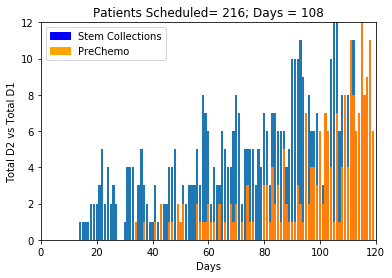

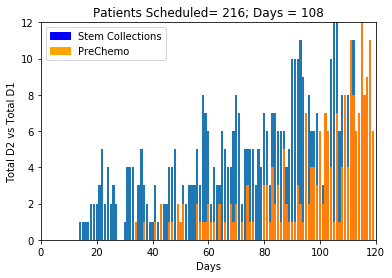

In [883]:
env.render(1,1)

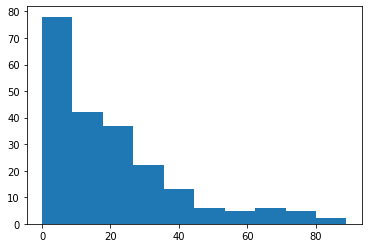

In [884]:
env.render(2)

In [885]:
env.sched2

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  2.,  1.,  2.,
        0.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  0.,  2.,
        0.,  1.,  0.,  2.,  1.,  2.,  0.,  1.,  0.,  3.,  1.,  1.,  0.,
        0.,  0.,  3.,  3.,  1.,  4.,  2.,  3.,  1.,  5.,  2.,  1.,  1.,
        1.,  3.,  2.,  1.,  7.,  2.,  4.,  4.,  3.,  6.,  2.,  7.,  6.,
        4.,  1.,  7.,  1.,  4.,  8.,  4., 11.,  8.,  6.,  7., 12.,  8.,
        9., 11.,  6.])

In [886]:
5*13 + 5

70

In [392]:
#Greedy Algo Step
#Make sure that pateints don't have stem collections over weekend
def greedyStep(env):
    sched = False
    for d1 in range(env.current_day,DAYS):
        for d2 in range(d1 + env.currentpatient_collection_day, DAYS):
            if(env.sched1[d1] < SLOTS1 and env.sched2[d2] < SLOTS2 and d1 >= env.current_day ):
                return np.array([d1,d2])
                
            
            

In [393]:
def greedyStep2(env,q):
    sched = False
    for d1 in range(env.current_day,DAYS):
        for i in range(q):
            if(env.sched1[d1] < SLOTS1 and env.sched2[d1 +env.currentpatient_collection_day+i] < SLOTS2 and d1 >= env.current_day and (d1%5) + env.currentpatient_collection_day <= 5):
                return np.array([d1,d1+env.currentpatient_collection_day+i])

In [1011]:
#Modified Greedy Algorithm, we need 
def modGreedyStep(env, window1, window2, back1 = True, back2 = True ):
    sched = False
    if(back1):
        start1 = -window1 +1
    else:
        start1 = 0
    
    if(back2):
        start2 = -window2+1
    else:
        start2 = 0
        
        
    for d1 in range(env.current_day,DAYS):
        for d2 in range(d1 + env.currentpatient_collection_day, DAYS):
            if(env.sched1[d1] < SLOTS1 and env.sched2[d2] < SLOTS2 and d1 >= env.current_day and (d1%5) + env.currentpatient_collection_day <=5 ):
                min_d1 = d1
                i = start1
                
                while(i < window1):
                    if(d1+i + env.currentpatient_collection_day+1 < DAYS):
                        if(env.sched1[min_d1] > env.sched1[d1+i]  and d1+i >= env.current_day and(d1+i)%5 + env.currentpatient_collection_day <= 5):
                            min_d1 = d1+i
                        
                    i += 1
                
                
                
                d2 += (min_d1 - d1)
                min_d2 = d2 
                j = start2
                while (j < window2):
                    if(d2 + j < DAYS):
                        if(env.sched2[min_d2] > env.sched2[d2+j] and env.sched2[d2+j] < SLOTS2 and d2+ j >= min_d1+env.currentpatient_collection_day):
                            min_d2 = d2+j
                            
                    j += 1
                
                
                return np.array([min_d1,min_d2])

In [1024]:
obs = env.reset()


In [1025]:
#ModGreedy Algo
time = 1000
step = 0
actions = []
img = []
window1 =7
window2 = 3
while step < time and env.current_day <=59:
    action =  modGreedyStep(env,window1,window2,False, False)
    actions.append(action)
    env.step(action)
    step +=1
    

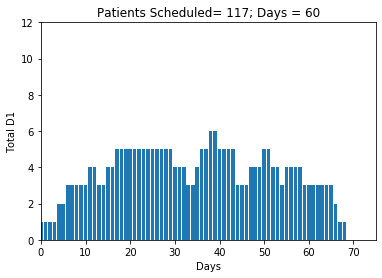

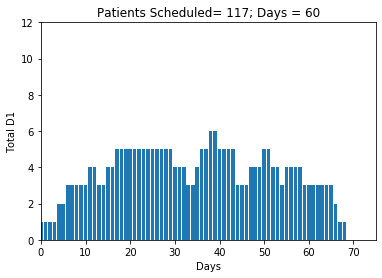

In [1026]:
env.render(2,1.6)

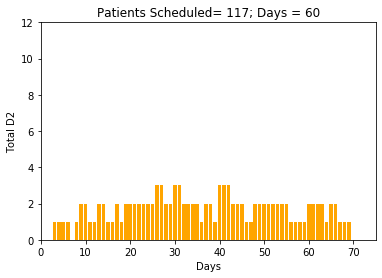

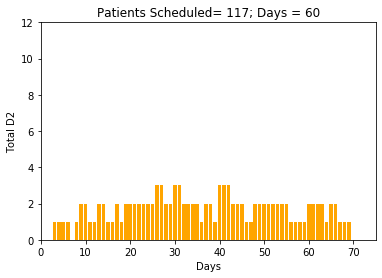

In [1027]:
env.render(3,1.6)

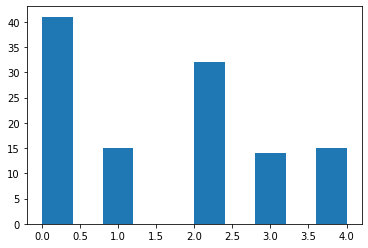

array([0., 0., 0., 0., 2., 0., 2., 0., 3., 2., 0., 4., 0., 0., 2., 3., 0.,
       2., 4., 2., 1., 3., 2., 4., 0., 1., 0., 0., 2., 3., 0., 4., 1., 3.,
       4., 2., 2., 0., 1., 2., 2., 0., 4., 0., 1., 0., 0., 0., 4., 3., 0.,
       1., 2., 0., 2., 1., 3., 0., 3., 4., 1., 2., 2., 2., 0., 0., 4., 0.,
       2., 0., 0., 1., 3., 3., 2., 1., 0., 4., 3., 4., 2., 1., 2., 0., 2.,
       3., 0., 0., 0., 4., 0., 2., 2., 2., 3., 3., 4., 0., 1., 1., 2., 0.,
       2., 2., 4., 2., 2., 1., 0., 0., 0., 2., 0., 4., 2., 1., 0.])

In [1029]:
env.render(4)
env.Q1

In [1017]:
obs = env.reset()

In [1018]:
#Greedy Algo
time = 1000
step = 0
actions = []
img = []
while step < time and env.current_day <=59:
    action = greedyStep2(env,4)
    actions.append(action)
    env.step(action)
    step +=1
    

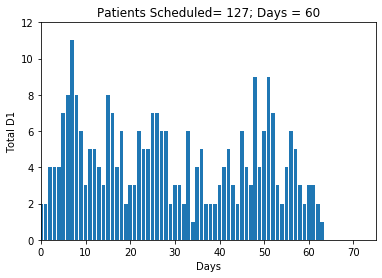

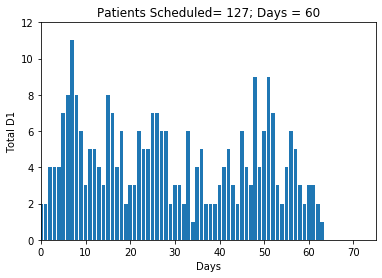

In [1019]:
env.render(2,1.6)

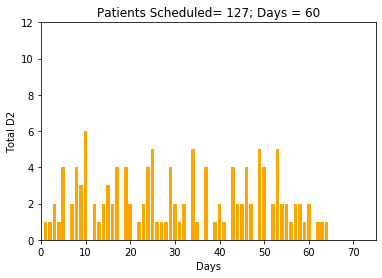

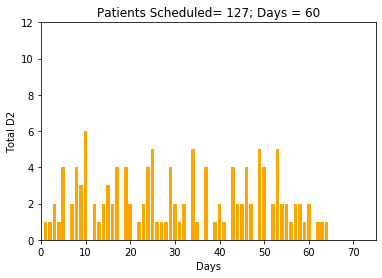

In [1020]:
env.render(3,1.6)

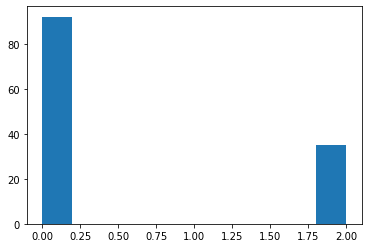

array([0., 2., 0., 0., 0., 2., 0., 0., 2., 2., 2., 2., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0.])

In [1023]:
env.render(4)


In [1022]:
env.Q1

array([0., 2., 0., 0., 0., 2., 0., 0., 2., 2., 2., 2., 2., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 2., 0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 2., 2., 0., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0.])

In [665]:
import matplotlib.cm as cm 

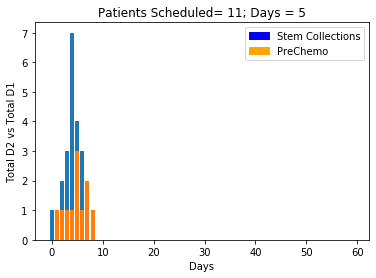

In [713]:
img[10]

In [735]:
import os
folder = "/home/nma5214/Desktop/IMA/Bone_Project/pics"

In [743]:
def generate_video(img):
    for i in range(len(img)):
        plt.plot(img[i])
        plt.savefig(folder + "/file%02d.png" % i)


TypeError: float() argument must be a string or a number, not 'Figure'

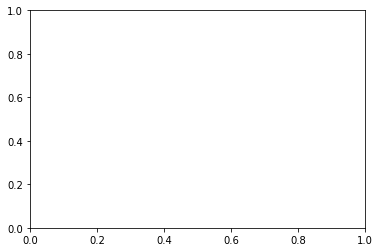

In [744]:
generate_video(img)

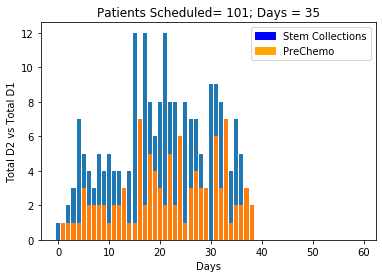

In [727]:
img[100]